In [1]:
import numpy as np
import scipy.signal as sp
import matplotlib.pyplot as plt
%matplotlib inline

**Tasks**
* Use DFMD on a Harmonic Oscillator with one frequency and completely filter it out

### One Oscillation Completely Filtered Out ###

In [2]:
def FT(y, dt, lim=None):
    """
        Plots the real Fourier Transform of a given function, y, and calculates the Nyquist frequency in Hz given
        the time step, dt, in seconds. x axis can be limited by the list, lim, which contains the upper and lower
        boundaries, [lower, upper], if desired.
    """
    Y = np.fft.rfft(y)
    freq = np.fft.rfftfreq(len(y), d=dt)
    plt.plot(freq, abs(Y), 'r')
    plt.xlim(lim)
    nyq = 1.0 / (2 * dt)
    return Y, freq
    print 'The Nyquist Frequency is', nyq, 'Hz'

def Convolve(signal, coeff):
    """
        Performs the discrete convolution of signal and filter coefficients. The signal must be greater in length
        than the filter coefficients.
    """
    conv = []
    a = len(coeff)  # how many coefficients in the filter
    sig = len(signal)  # how many coefficients in the signal
    m = sig - a + 1  # difference in signal and coefficient length + 1 to get range, +1 to make sure all steps are done
    
    if a > sig:
        return 'The signal must have more coefficients than the filter'
    else:
        for i in range(m):  
            # coeffs line up with the signal and multiply, sum together, a+i moves coeff with each loop
            b = sum(np.array(signal[i:a+i]) * np.array(coeff))
            conv.append(b)
        return conv

In [3]:
def Filter(numtaps, bands, desired):
    """
        Provides filter coefficients for DFMD
        ---------------
        PARAMETERS
        ---------------
        numtaps:length of the filter, must be odd
        bands: desired bands of the filter, must be in pairs, list
        desired: the desired frequency response of the filter, must have the same number of values as bands, list
    """
    Coeff = sp.firls(numtaps, bands, desired)
    return Coeff

# Frequency Response of the Filter
def FreqResponse(coeff, lim=None):
    freq1, response = sp.freqz(coeff)
    plt.plot(freq1/np.pi, np.abs(response), 'r') # added nyq here
    plt.xlim(lim)
    plt.xlabel('f / nyq_f')
    plt.ylabel('Relative amplitudes')

def F(r, k=100):
    """
        Force on a particle in a Harmonic Oscillator
    """
    f = -k * r
    return f

def Kinetic(v_trj):
    kin = []
    for v in v_trj:
        kin.append(0.5 * 1 * (v ** 2))
    return kin

def Potential(r_trj):
    pot = []
    for r in r_trj:
        pot.append(0.5 * 100 * (r ** 2))
    return pot

def MD(r, v, t, dt, m=1):
    """
        Velocity verlet algorithm for one particle
        ---------------
        PARAMETERS
        ---------------
        r: initial position, m
        v: initial velocity, m/s
        t: initial time, s
        dt: time step, s
        m: mass of particle in oscillator, set at 1 kg
    """
    v = v + (dt / (2 * m)) * F(r)
    r = r + (dt * v)
    v = v + (dt / (2 * m)) * F(r)
    t = t + dt
    return v, r, t

def ApplyFilter(signal, coeff): # multiplies signal and coeffs and adds them together to get a single value
    """
        Multiplies a signal and coefficients and adds them together to get a single filtered value
        ---------------
        PARAMETERS
        ---------------
        signal: input signal to be filtered
        coeff: filter coefficients
    """
    a = len(coeff)
    Filtered = np.sum(np.array(signal[0:a])*np.array(coeff))
    return Filtered

def Buffer(coeff, r, v, t, dt, filter_freq):
    """
        Collects velocities in a buffer of len(coeff) + D and applies two filters that are pi/2 apart
        returning two filtered velocities and the position at the midpoint of the first filter.
        ---------------
        PARAMETERS
        ---------------
        coeff: the filter coefficients
        r: position
        v: velocity
        t: time
        dt: time step
    """
    D = 1.0 / (4 * filter_freq * dt)
    Buffer = len(coeff) + int(D)
    cf = len(coeff)
    buff = []
    r_buff = []
    for md in range(Buffer):
        trj = MD(r, v, t, dt)
        buff.append(trj[0])
        r_buff.append(trj[1])
        v = trj[0]
        r = trj[1]
        t = trj[2]
            
        if len(buff) == Buffer:
            v_fil1 = ApplyFilter(buff[:cf], coeff)
            v_fil2 = ApplyFilter(buff[int(D):int(D+cf)], coeff)
            mid_r = r_buff[(cf+1)/2]
    return mid_r, v_fil1, v_fil2
        
    
def DFMD(r, v, t, dt, MDStep, Total, coeff, filter_freq):
    """ 
        Digitally filtered molecular dynamics of a particle in a Harmonic Oscillator
        ---------------
        PARAMETERS
        ---------------
        r: initial position, m
        v: initial velocity, m/s
        t: initial time, s
        dt: time step, s
        MDStep: number of MD steps before the buffer starts to fill
        Total: total number of steps of the simulation
        coeff: filter coefficients
        filter_freq: the target frequency to be enhanced or supressed
    """
    # Trajectories
    v_trj = [v]
    r_trj = [r]
    t_trj = [t]
    mid = (len(coeff)+1)/2
    D = 1.0 / (4 * filter_freq * dt)
    print int(D), 'steps delay between filter pulses'
    
    # MD runs for a given number of steps before the buffer starts to fill
    for md in range(MDStep):
        trj = MD(r, v, t, dt)
        v_trj.append(trj[0])
        r_trj.append(trj[1])
        t_trj.append(trj[2])
        v = trj[0]
        r = trj[1]
        t = trj[2]
    
    mid_r, v_fil1, v_fil2 = Buffer(coeff, r, v, t, dt, filter_freq)
    
    # Adds the first half of the first buffer to the trajectories
    for md in range(mid):
        trj = MD(r, v, t, dt)
        v_trj.append(trj[0])
        r_trj.append(trj[1])
        t_trj.append(trj[2])
        v = trj[0]
        r = trj[1]
        t = trj[2]
        
    # Application of the first filter and MD continues for D steps
    r = mid_r
    v = v_fil1
    v_trj.append(v)
    r_trj.append(r)
    t_trj.append(t)
    t = t + dt
    print 'First filter applied at', t, 'seconds'
    for md in range(int(D)):
        trj = MD(r, v, t, dt)
        v_trj.append(trj[0])
        r_trj.append(trj[1])
        t_trj.append(trj[2])
        v = trj[0]
        r = trj[1]
        t = trj[2]
        
    # Application of the second filter and MD continues
    v = v_fil2
    v_trj.append(v)
    r_trj.append(r)
    t_trj.append(t)
    t = t + dt
    print 'Second filter applied at', t, 'seconds'
    
    for md in range(Total - int(D) - MDStep - mid - 2):
        trj = MD(r, v, t, dt)
        v_trj.append(trj[0])
        r_trj.append(trj[1])
        t_trj.append(trj[2])
        v = trj[0]
        r = trj[1]
        t = trj[2]
    
    kin = Kinetic(v_trj)
    pot = Potential(r_trj)
    
    print 'DFMD Complete'
    return v_trj, r_trj, t_trj, kin, pot

In [19]:
filter_freq = (1.0 / (2 * np.pi)) * np.sqrt(100 / 1)
v = np.random.randn()
Coeff = Filter(1001, [0, 0.1, 0.11, 1], [0, 0, 0, 0])  # Coefficients to eliminate signal
v_trj, r_trj, t_trj, kin, pot = DFMD(0, v, 0, 0.001, 1500, 5000, Coeff, filter_freq)

157 steps delay between filter pulses
First filter applied at 2.002 seconds
Second filter applied at 2.16 seconds
DFMD Complete


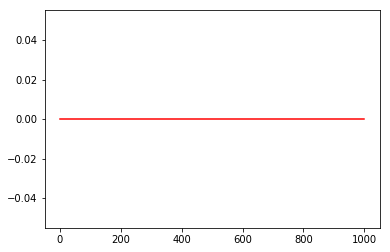

In [15]:
# Plot of the filter
plt.plot(Coeff, 'r')

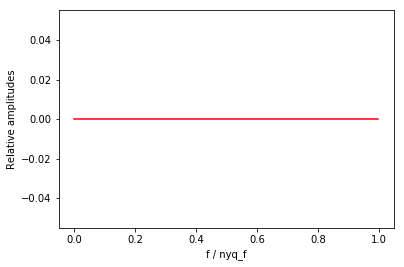

In [16]:
# Plot of the frequency response of the filter
FreqResponse(Coeff)

(0, 3000)

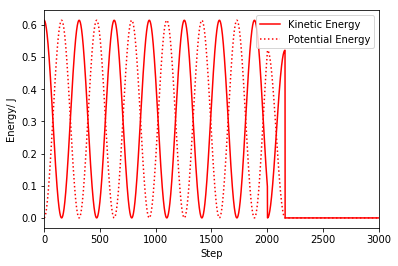

In [20]:
plt.plot(kin, 'r', label='Kinetic Energy')
plt.plot(pot, 'r:', label='Potential Energy')
plt.xlabel('Step')
plt.ylabel('Energy/ J')
plt.legend()
plt.xlim([0, 3000])

**Does this make sense?**
* Told to run 1500 MD steps before buffer starts filling (1500)
* Buffer has 1001 coefficients, the midpoint will be 501 (2001)
* There are 157 steps delays between filter pulses       (2158)
* MD continues until 5000 steps reached                  (5000)

Expect to see the first filter pulse at 2001 steps - This looks as if it matches the energy plot above

Expect to see the second filter pulse at 2158 - This also looks as if it matches the energy plot

When plt.xlim() is not used the energy plot goes to 5000 steps as expected

Text(0,0.5,u'Velocity/ $ms^{-1}$')

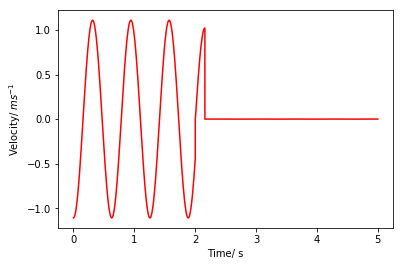

In [21]:
plt.plot(t_trj, v_trj, 'r')
plt.xlabel('Time/ s')
plt.ylabel('Velocity/ $ms^{-1}$')